# Quantum states with high dimensional entanglement

This notebook allows visualizing the 20 circuits of the second pilot study with mention of their depth and gate repartition.

At the end, a toy protocol of ballot transmission is presented with experimental verification.

In [1]:
import numpy as np
import copy
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.tools.visualization import *
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import json
import time
from qiskit.tools.monitor import job_monitor
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
from c_utils import new_cut # circuit building utilities
from o_utils import ora

In [3]:
data_directory = "data2_files/" # this directory for 2d pilot project data
def json_dic_loader(dic_name):
    f = open(data_directory+dic_name+'.json')
    return json.load(f)
def json_dic_dumper(dic, dic_name):
    with open(data_directory+dic_name+'.json', 'w') as f:
        json.dump(dic,f)   

## Set up the simulator and layout for 5 qubits

In [4]:
simulator = Aer.get_backend('qasm_simulator')

In [5]:
#specify the layout of the devices
used_qubits = 5
qubit_list = [0,1,2,3,4]

In [6]:
program_name="AL2" # This for a mix of W/Psi+ and W_bar/Phi+ separable states (2d pilot project)
Flag_char = "DS" # use the joint set
if len(Flag_char) >= 2:
    unique_char = "M" # for "mixed"
else:
    unique_char = Flag_char

###### OLD VERSION TO BE DELETED These dictionaries for the devices used in the study
QV_dic = {'ibmq_athens': 32.0, 'ibmq_valencia': 16.0, 'ibmq_ourense': 8.0, 
          "ibmqx2": 8.0, 'ibmq_santiago': 32.0, 'ibmq_vigo': 16.0, 'ideal_device': np.inf}
dev_dic =  {'ibmq_santiago': "San",'ibmq_athens': "Ath", 'ibmq_valencia': "Val", 'ibmq_vigo': 'Vig','ibmq_ourense': "Our",
               "ibmqx2": 'Yor',  'ideal_device': "Ide"}

In [7]:
# These dictionaries for the devices used in the study
if program_name == "QAD":
    fidelity_dic = {'ibmq_athens': 0.925110, 'ibmq_valencia': 0.809101, 'ibmq_ourense': 0.802380,"ibmqx2": 0.627392, 
                    'ibmq_santiago': 0.919399, 'ibmq_vigo': 0.908840, 'ibmq_lima':0.771835, 'ideal_device': 1.0}
    data_directory = "data_files/"
elif program_name == "AL2":
    fidelity_dic = {'ibmq_athens': 0.910145, 'ibmq_valencia': 0.794262, 'ibmq_ourense': 0.818974, "ibmqx2": 0.359528,
                    'ibmq_santiago': 0.900024, 'ibmq_vigo': 0.841831, 'ibmq_quito': 0.839985, 'ibmq_lima':0.771835,
                    'ibmq_belem':0.842281,'ideal_device': 1.0}
    data_directory = "data2_files/"
QV_dic = {'ibmq_athens': 32.0, 'ibmq_valencia': 16.0, 'ibmq_ourense': 8.0,"ibmqx2": 8.0, 'ibmq_santiago': 32.0,
          'ibmq_vigo': 16.0, 'ideal_device': np.inf,  'ibmq_quito': 16.0, 'ibmq_lima': "Lim",'ibmq_belem':16.0}
dev_dic =  {'ibmq_santiago': "San",'ibmq_athens': "Ath", 'ibmq_valencia': "Val", 'ibmq_vigo': 'Vig','ibmq_ourense': "Our",
               "ibmqx2": 'Yor', 'ibmq_quito': "Qui", 'ibmq_lima': "Lim", 'ibmq_belem': "Bel",'ideal_device': "Ide" }

In [8]:
# specify the device: here first the ideal noise-free device
project_device = 'ideal_device'
device_name = dev_dic[project_device]

In [9]:
# specify the nb of id gates between state creation and measurements
# zero for the ideal device of course
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))

In [10]:
# tail of the file names for RAM storage
mitig_name = program_name + "_" + device_name
project_name = mitig_name + "_" + unique_char + zfilled
print(mitig_name)
print(project_name)

AL2_Ide
AL2_Ide_M000


In [11]:
# establish the result label list
# meas_calibs will be used for mitigation in the real device section
qr = QuantumRegister(used_qubits) # 
meas_calibs, label_list = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
nb_labels=len(label_list)
print(nb_labels,label_list)

32 ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [12]:
len(meas_calibs)

32

In [13]:
# permutation list
# here it is simple to write down the list, 
# but a version using itertools will be wellcome for >5 qubits projects
q_perm = [[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [0, 1, 4, 2, 3], [0, 2, 3, 1, 4], [0, 2, 4, 1, 3],
          [0, 3, 4, 1, 2], [1, 2, 3, 0, 4], [1, 2, 4, 0, 3], [1, 3, 4, 0, 2], [2, 3, 4, 0, 1]]

## Create the quantum states


In [14]:
# define the two subsets of 10 separable states
if program_name == "QAD":
    state_1a = ["W","Phi+"]
    state_1b = ["GHZ","Psi+"]
elif program_name == "ALT" or "AL2":
    state_1a = ["W","Psi+"]
    state_1b = ["Wbar","Phi+"]
l_states = state_1a+state_1b

In [15]:
l_states

['W', 'Psi+', 'Wbar', 'Phi+']

In [16]:
# version 20 circuits for demonstration
# (in the version run on real devices: two batches of 10 circuits)

# these circuits limited to state creation are ready to be saved 
# for  ultimately building circuits adapted to noisy simulator and real devices
# as option, these circuits will include a row of id gates between creation and measurements

circ_ori = []
for i_s in range(0,len(l_states),2):
    for perm in q_perm:
            mycircuit = QuantumCircuit(used_qubits, used_qubits)                                   
            mycircuit = new_cut.circuit_builder(mycircuit, perm, l_states[i_s],l_states[i_s+1])
            circ_ori.append(mycircuit)

In [17]:
# add measurement section to the circuit set newly created:
nb_states = len(circ_ori)
circ_ideal = copy.deepcopy(circ_ori)
for i_state in range(nb_states):
    new_cut.add_barrier_and_measure(circ_ideal[i_state],qubit_list)

## Obtain result distributions on  noise free simulator

In [18]:
# execute on noise free simulator  
s_sim = 12000
job_simul = execute(circ_ideal, backend=simulator, shots=s_sim)
tot_results_simul = job_simul.result()

In [19]:
# establish a dictionary of count results on noise free simulator:
# (this step is only useful if ram storage is performed)
void_counts = dict(zip(label_list, np.full(2**used_qubits,0.0))) #, dtype=int)))
tot_results_sim_dic = {}
ideal_dic = {}
for i_state in range(nb_states):
    counts_simul = copy.deepcopy(void_counts)
    counts_simul.update(tot_results_simul.get_counts(i_state))
    ideal_dic[str(i_state)]=counts_simul

Example of circuit for separable state of the first type : $|W\rangle\otimes|\Psi^+\rangle$

Ide circuit # 5


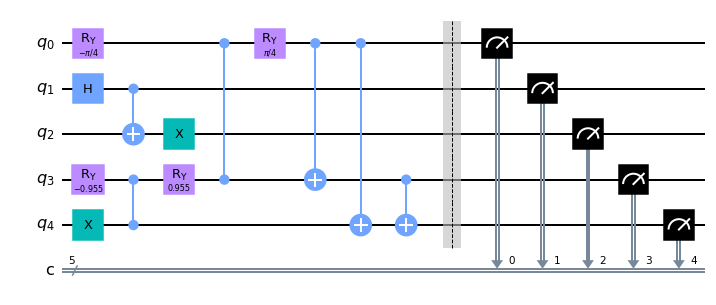

In [20]:
i_state_test = 5
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 5


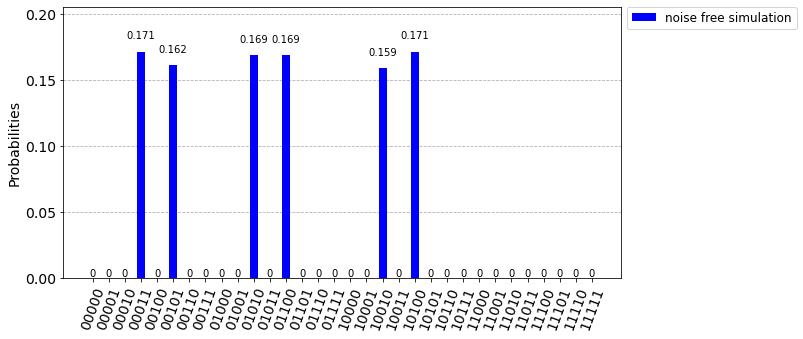

In [21]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

Example of circuit for separable state of the second type : $|W\rangle^{\otimes X}\otimes|\Phi^+\rangle$

Ide circuit # 15


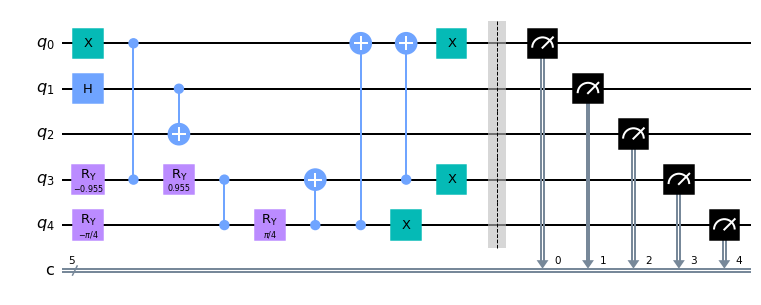

In [22]:
i_state_test = 15
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 15


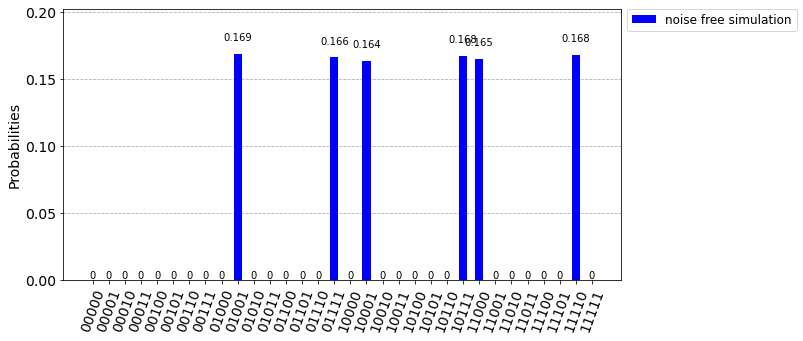

In [23]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [24]:
def print_first_and_last_row(PDM):
    print("first and last rows of the probability distribution matrix of dimension "+str(nb_states)+"x"+str(nb_labels))
    print(np.round(PDM[0:1,:],4))
    print("   ...")
    print(np.round(PDM[-1:,:],4))

In [25]:
PD_ideal =  np.ndarray((nb_states,nb_labels))
for i_state in range(nb_states):
    PD_ideal[i_state, :] = list(ideal_dic[str(i_state)].values())
# now a little trick to get the ideal values from the simulator approximated values
with np.errstate(divide='ignore'): # ignore the divide by zero warning
    PD_ideal = 1/np.round(s_sim/(PD_ideal))
# have a look at the matrix head and tail:
print_first_and_last_row(PD_ideal)

first and last rows of the probability distribution matrix of dimension 20x32
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1667
  0.1667 0.     0.1667 0.     0.     0.     0.     0.1667 0.1667 0.
  0.1667 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.    ]]
   ...
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.1667 0.     0.     0.1667 0.     0.     0.     0.
  0.1667 0.     0.     0.1667 0.1667 0.     0.     0.1667 0.     0.
  0.     0.    ]]


# Real device section

In [26]:
from qiskit import IBMQ

In [27]:
IBMQ.load_account()

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [28]:
provider = IBMQ.get_provider(hub='ibm-q')

In [29]:
print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>]


In [30]:
project_device = 'ibmq_belem'# you may choice here a different backend
device_name = dev_dic[project_device]
mitig_name = program_name + "_" + device_name
print(mitig_name)

AL2_Bel


In [31]:
# determine here the backend
device = provider.get_backend(project_device) # the backend names are listed here above
properties = device.properties()
coupling_map = device.configuration().coupling_map

### Load circuits run on real device
 

In [32]:
id_gates = 0 # choice of 0 or 256 at this time
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))
project_name = mitig_name + "_" + unique_char + zfilled
print(project_name)

AL2_Bel_M000


In [33]:
circuit_dic = json_dic_loader("circuit_"+ project_name)

In [34]:
real_circs = []
for i_state in list(range(nb_states)): 
    real_circs.append(QuantumCircuit().from_qasm_str(circuit_dic[str(i_state)]))  

In [35]:
i_state_test = 11
print(project_device, "circuit #",i_state_test,
      "circuit depth:",real_circs[i_state_test].depth())
print('gates = ',real_circs[i_state_test].count_ops())

ibmq_belem circuit # 11 circuit depth: 70
gates =  OrderedDict([('rz', 38), ('sx', 33), ('cx', 22), ('measure', 5), ('x', 4), ('u1', 2), ('barrier', 1)])


In [36]:
if id_gates <= 16:
# you may want to skip this if large nb of id gates before measurement
    real_circs[i_state_test].draw(output='mpl')
else:
    print("skipped")

## Histogram on simulator

ibmq_belem circuit # 11 on noise free simulator


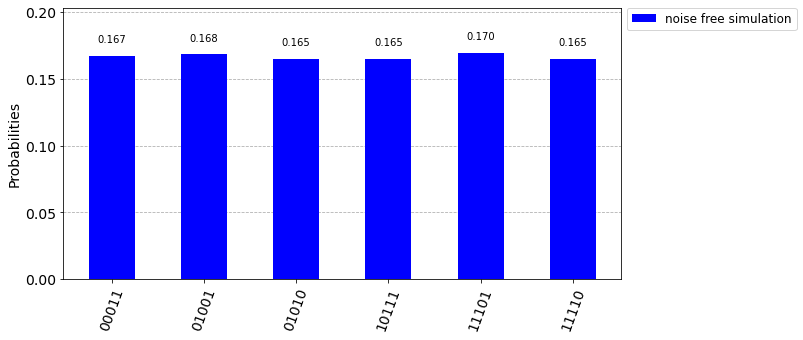

In [37]:
job_simul = execute(real_circs[i_state_test], backend=simulator, shots=s_sim)
print(project_device, "circuit #",i_state_test, "on noise free simulator")
simul_results = job_simul.result().get_counts()
plot_histogram(simul_results,
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

# Results on real device

### Obtain mitigation filter

In [38]:
# retrieve the corresponding measurement mitigation filter obtained at experimental time
# use a fake job because the calibration results were stored as dictionary
simulator = Aer.get_backend('qasm_simulator')
fake_job_cal = execute(meas_calibs, backend=simulator, shots=1)
fake_cal_results = fake_job_cal.result()
cal_results_dic = json_dic_loader("cal_results_dic_"+mitig_name)

In [39]:
if 'date' in cal_results_dic.keys():
    str(cal_results_dic['date'])

In [40]:
cal_results = fake_cal_results.from_dict(cal_results_dic)

In [41]:
meas_fitter = CompleteMeasFitter(cal_results, label_list, qubit_list=qubit_list, circlabel='mcal')
meas_filter = meas_fitter.filter
# have a look at the average measurement fidefily of this device:
print("Average Measurement Fidelity was: %f" % meas_fitter.readout_fidelity(), "for",project_device)

Average Measurement Fidelity was: 0.842281 for ibmq_belem


### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [42]:
empirical_dic = json_dic_loader('experimental_'+project_name)
test_dic = json_dic_loader('test_'+project_name) 

In [43]:
def rectify_counts(tot_res, test_cqi,mitigation,m_filter) :       
        
        void_counts = dict(zip(label_list, np.zeros(2**used_qubits)))
        try:
            counts_results_real_test = tot_res[test_cqi]
        except KeyError as error:            
            counts_results_real_test = tot_res[str(test_cqi)]

        raw_counts_test = copy.deepcopy(void_counts)
        raw_counts_test.update(counts_results_real_test)

        if mitigation:
            mitigated_results_test = meas_filter.apply(raw_counts_test, method = 'least_squares')
            returned_counts = copy.deepcopy(void_counts)
            returned_counts.update(mitigated_results_test)
                        
        else:
            returned_counts = copy.deepcopy(raw_counts_test)
            
        return returned_counts

In [44]:
def get_clean_matrix(dic, mitigation,m_filter):
    clean_matrix =  np.ndarray((nb_states,nb_labels)) 
    for i_state in range(nb_states):
        rectified_counts = rectify_counts(dic,i_state, mitigation,m_filter) # get a rectified counts dictionary       
        clean_matrix[i_state, :] = list(rectified_counts.values())
    clean_matrix = clean_matrix/clean_matrix.sum(axis=1, keepdims=True)
    return clean_matrix

def obtain_pooled_PDM(mitigation):
    PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                                m_filter=meas_filter)
    PD_test = get_clean_matrix(test_dic, mitigation=mitigation,
                                m_filter=meas_filter)
    return PD_exper + PD_test

In [45]:
PD_tot = obtain_pooled_PDM(mitigation=False)/2
PD_totm = obtain_pooled_PDM(mitigation=True)/2

ibmq_belem circuit # 11 circuit depth: 70
gates =  OrderedDict([('rz', 38), ('sx', 33), ('cx', 22), ('measure', 5), ('x', 4), ('u1', 2), ('barrier', 1)])


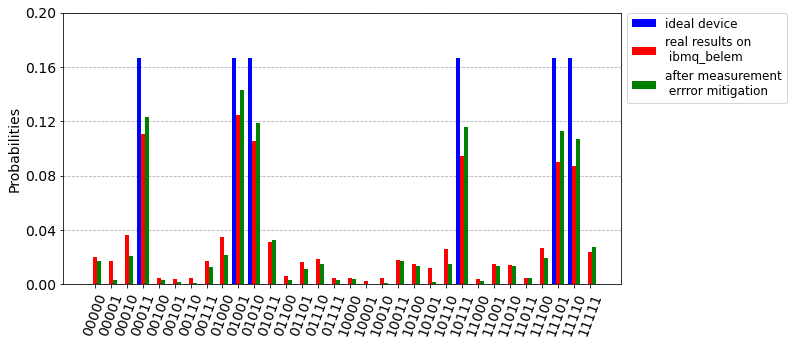

In [46]:
i_state_test = 11 # choose here the circuit
print(project_device, "circuit #",i_state_test,
      "circuit depth:",real_circs[i_state_test].depth())
print('gates = ',real_circs[i_state_test].count_ops())

ideal_results = dict(zip(label_list,PD_ideal[i_state_test]))
real_results = dict(zip(label_list,PD_tot[i_state_test]))
mit_results = dict(zip(label_list,PD_totm[i_state_test]))

plot_histogram([ideal_results, real_results, mit_results],
               legend=['ideal device','real results on\n '+ project_device, 'after measurement\n errror mitigation'],
               color =["b","r","g"],
               bar_labels=False,
               figsize=(10.,5.))

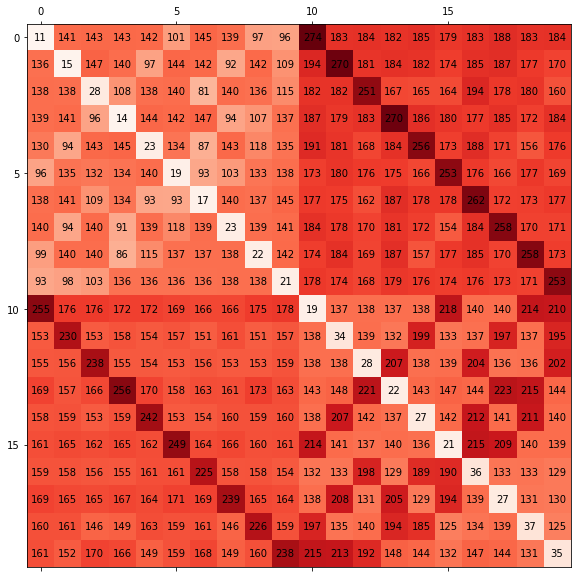

In [47]:
# Matrix of distances between distributions
# Numbers in squares are "distances expressed per thousand", thus from 0 to 1000

Y_dist_tot = cdist(PD_tot,PD_ideal, metric='sqeuclidean') 
# !cdist(1st matrix -> Y rows, 2d matrix -> Y columns)  
 
# adapted from https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap:
fig, ax = plt.subplots(figsize=(10.,10.))
figsize=(20.,20.)
min_val, max_val =  np.min(Y_dist_tot), np.max(Y_dist_tot)
ax.matshow(Y_dist_tot, cmap=plt.cm.Reds)
for i in range(20):
    for j in range(20):
        c = round(1000*Y_dist_tot[j,i])
        ax.text(i, j, str(c), va='center', ha='center')

# Transmission protocol

In this toy example, the ballots of 10 voters are transmitted from Alice's vote station to Bob through a 5-qubit quantum channel.

- Each voter possesses a secret key consisting of one of the possible combinations of three out of five qubits.

- For "Yes", the voter creates as valid state the corresponding $W\otimes\Psi^+$ state and for "No" the corresponding $\bar{W}\otimes\Phi^+$ state. This state is stored on quantum RAM.

- For check, the voter creates the discarded state, which is also stored on RAM.

- When all votes are obtained, the pairs of valid and discarded states are shuffled to preserve confidenciality.

- The sets of valid and discarded states are sent separately to Bob, who measures them.

- Bob checks if all voter keys are different within and over the sets and if the second set is the mirror of first.
 one.
 
- From these checks, Bob proclaims the result of the vote or reports irregularities.

In [120]:
# safe shot number:
if id_gates == 0:
# for the case: mitigation, empirical model, no time delay, squared euclidean distance
    copies_dic =  {'ibmq_santiago': 27,'ibmq_athens': 32, 'ibmq_valencia': 25,
                   'ibmq_vigo': 25,'ibmq_ourense': 30, "ibmqx2": 209,'ibmq_quito': 35,
                   'ibmq_lima':29,'ibmq_belem':25,'ideal_device': 16}
elif id_gates == 256:
# for the case: mitigation, empirical model, 256 id gates time delay, squared euclidean distance
    copies_dic =  {'ibmq_santiago': 46,'ibmq_athens': 45, 'ibmq_valencia': 32,
                   'ibmq_vigo': 37,'ibmq_ourense': 35, "ibmqx2": 253,'ibmq_quito': 74,
                   'ibmq_lima':61,'ibmq_belem':44,'ideal_device': 16}

In [121]:
def get_circ_results(circs_list, option, retrieve_job):
    c_list = []
    result_list=[]    
    count_list=[]
    
    if option != "draw":
        if option == "run":
            dict_counts = dict(zip(label_list, np.full(2**used_qubits,0.0)))
            circ_job=[]
            for i_state in circs_list:
                circ_job.append(real_circs[i_state])
            time_exp = time.strftime('%d_%m_%Y_%H_%M_%S')
            print("DMY: ",time_exp) 
            job_real = execute(circ_job,
                               backend = device,
                               optimization_level=0,
                               shots=copies_dic[project_device])
            job_real_id = job_real.job_id()
            print("job id:", job_real_id)
            job_monitor(job_real)
            time_exp = time.strftime('%d_%m_%Y_%H_%M_%S')
            print("DMY: ",time_exp, "job id:", job_real_id)
        
        elif option == "retrieve":    
            job_real = device.retrieve_job(retrieve_job)
                
        tot_results_real = job_real.result().get_counts()
        
        for cqi in range(len(circs_list)):
            counts = rectify_counts(tot_results_real,
                                cqi, mitigation=True, 
                                m_filter = meas_filter)
            result = list(counts.values())
            count_list.append(counts)
            result_list.append(result)          
            
    elif option == "draw":        
        
        for i_state in circs_list:
            result = (ora.obtain_rnd_samples(copies_dic[project_device],
                                             PD_totm[i_state].reshape(1,len(label_list))))
            counts = dict(zip(label_list, result.tolist()[0]))
            count_list.append(counts)
            result_list.append(result)
        
    for i in range(len(circs_list)):        
        sample = np.array(result_list[i]).reshape(1,len(label_list)) # cdist requires 2D arrays      
        Y_dist = cdist(PD_totm,sample,metric='sqeuclidean')        
        c_list.append(np.argmin(Y_dist))
   
    return np.array(c_list), count_list

Three option are offered:
    
    - draw: no experimental data but probability distribution vectors drawn from the best PDM estimate
    - retrieve : data for a real-device experiment 
    - run : your own experiment, requires knowing the corresponding safe shot number 


In [122]:
# choose option among "draw", "retrieve" or "run")

option = "retrieve" # this for demo, use 'draw' if you don't have access to the provider

ballots_job = None
discard_job = None
if option == "retrieve":
# if other jobs to retrieve, add it here:
    if project_device == 'ibmq_santiago' and id_gates == 0:
        ballots_job = "601431a1009c57184251fd75" 
        discard_job = "6014468a33e5610c14ba32f3" 
        votes = [1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
        ballots = [ 0, 11, 12, 13, 14, 15,  6,  7,  8,  9]
        discard = [10,  1,  2,  3,  4,  5, 16, 17, 18, 19]
        
    elif project_device == 'ibmq_santiago' and id_gates == 256:
        ballots_job = "6016ab0e31750877f41b8065" 
        discard_job = "6016b05d2e48d200fa8313b4" 
        votes = [0, 1, 1, 0, 0, 0, 0, 1, 1, 0]
        ballots = [18,  1,  2, 13, 14, 19, 10,  7,  5, 16,]
        discard = [ 8, 11, 12,  3,  4,  9,  0, 17, 15,  6]
    
    elif project_device == 'ibmq_athens' and id_gates == 0:
        ballots_job = "60151b8ae22886f085850545" 
        discard_job = "60152b0b691ba121c061a7a8" 
        votes = [1, 1, 1, 1, 0, 1, 0, 0, 0, 1]
        ballots = [ 0, 1, 2, 3, 14, 5,  16,  17,  18,  9]
        discard = [10,  11,  12,  13,  4,  15, 6, 7, 8, 19]
        
    elif project_device == 'ibmq_athens' and id_gates == 256:
        ballots_job = "6015e1053757e808bad4827d" 
        discard_job = "6015f630834cac24de76f193" 
        votes = [1, 0, 1, 1, 1, 0, 1, 0, 1, 1]
        ballots = [ 4, 15,  8,  9,  7, 12,  0, 16,  3,  1]
        discard = [14,  5, 18, 19, 17,  2, 10,  6, 13, 11]
    
    elif project_device == 'ibmqx2' and id_gates == 0:    
        ballots_job = "6015a2d02e48d2c379830956" 
        discard_job = "6015a4b23b717dc22fa6f5de" 
        votes = [1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
        ballots = [ 0, 1, 2, 3, 14, 5,  6,  17,  18,  9]
        discard = [10,  11,  12,  13,  4,  15, 16, 7, 8, 19]
    
    else:
        print("no data for these jobs")
else:
    rng = np.random.default_rng()
    votes = rng.integers(0,2,10)
    
    discard = np.array(range(0,10)) + votes*10
    rng.shuffle(discard)
    ballots = (discard - 10) %20
print(ballots, discard)
print("YES:", int(sum(votes)), "  NO:", 10 - int(sum(votes)))

[18, 1, 2, 13, 14, 19, 10, 7, 5, 16] [8, 11, 12, 3, 4, 9, 0, 17, 15, 6]
YES: 4   NO: 6


In [123]:
# from state creation to measurement
t_ballots, c_ballots = get_circ_results(ballots, option, retrieve_job = ballots_job)
t_discard, c_discard = get_circ_results(discard, option, retrieve_job = discard_job)

In the example presented in this notebook (santiago 256 id gates, option = retrieve) , there was a transmission error in the ballot set, but not in the discard set. 

Bob detects the error and uses the alternate set, most probably error free.  

In [124]:
# check obtained circuit lists
t_total=np.hstack((t_ballots,t_discard))
flag_total = len(t_total) == len(set(t_total))
flag_ballots = len(t_ballots) == len(set(t_ballots%len(t_ballots)))
flag_discard = len(t_discard) == len(set(t_discard%len(t_discard)))
flag_equiv = np.array_equiv(t_discard, (t_ballots - 10)%20)
print(device, "- id gates:", id_gates,
      "- shots:", copies_dic[project_device], "- option:", option)
print("check all:", flag_total, "- check equivalence:", flag_equiv,
      "- check ballots:", flag_ballots, "- check discard:",flag_discard)
print(t_ballots, t_discard)

# report from the apparently correct set 
if (flag_ballots and not flag_equiv) or (flag_equiv and flag_total and flag_ballots and flag_discard):
    no = int((sum(t_ballots) - sum(range(0,10)))/10)
    yes = len(t_ballots) - no
    
elif flag_discard and not flag_equiv: 
    yes = int((sum(t_discard) - sum(range(0,10)))/10)
    no = len(t_discard) - yes

if flag_ballots or flag_discard:
    print("YES:", yes, " NO:", no)          
else:
    print("error(s) in ballot transmission")

ibmq_santiago - id gates: 256 - shots: 46 - option: retrieve
check all: False - check equivalence: False - check ballots: False - check discard: True
[18  1  2 13 14 19 10  7  0 16] [ 8 11 12  3  4  9  0 17 15  6]
YES: 4  NO: 6


Have a closer look at the error in the notebook example:

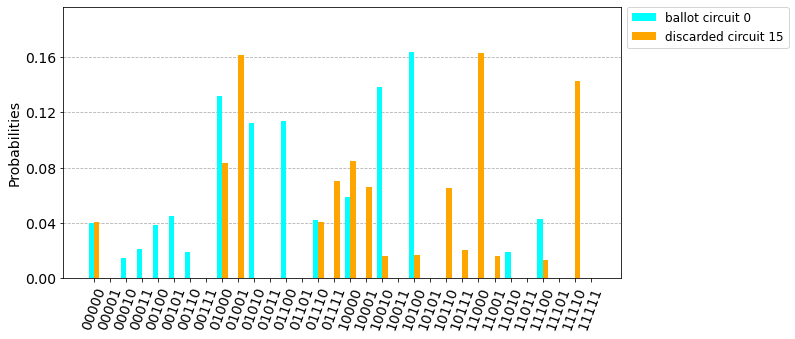

In [125]:
# look at some transmitted state and its supposed "W-mirrored"
v_nb = 8 # in range(0,10), original votes shuffled for confidentiality
plot_histogram([c_ballots[v_nb], c_discard[v_nb]],
               legend=['ballot circuit '+str(t_ballots[v_nb]),
                       'discarded circuit '+str(t_discard[v_nb])],
               color =["cyan","orange"],
               bar_labels=False,
               figsize=(10.,5.))

In [126]:
import qiskit.tools.jupyter
%qiskit_version_table